# 97: Simple machine learning model to predict emergency department (ED) breaches of the four-hour target

In England emergency departments have a target that 95% of patients should be admitted or discharged from ED within four hours. Patients waiting more than four hours are known as 'breaches'

This notebook explores predicting emergency department (ED) breaches (patients taking more than 4 hours to be discharged or admitted).

The model receives data every 2 hours and predicts whether there will be a breach in the next 2 hours.

It uses some basic ED data alongside whole-hospital data (number of occupied beds and total beds) to try to predict whether there are likely to be breaches in the next two hours. It uses a simple logistic regression model to achieve 80% accuracy in predicting breaches. Sensitivity may be adjusted to balance accuracy in predicting beach and non-breaching episodes (80% accuracy may be be simultaneousness achieved in both).

## Load and process data

Data is available at https://gitlab.com/michaelallen1966/1804_python_healthcare_wordpress/blob/master/data/ed_1.csv. 

Download the data file and save it in the same directory as the python code file you will build up.

This code can also be downloaded:

py file: https://gitlab.com/michaelallen1966/1804_python_healthcare_wordpress/blob/master/py_files/0097_ED_breach_prediction_pilot.py

jupyer-notebook: https://gitlab.com/michaelallen1966/1804_python_healthcare_wordpress/blob/master/jupyter_notebooks/0097_ED_breach_prediction_pilot.ipynb


In [1]:
import pandas as pd
data = pd.read_csv('ed_1.csv')

Show data columns:

In [2]:
print (list(data))

['snapshot_id', 'snapshot_date', 'snapshot_time', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Number of Patients In department >= 4 Hours', 'Total Number of Patients in the Department', 'Number of Patients in Resus', 'Number of Patients Registered in Last 60 Minutes', 'Number of Patients Waiting Triage', 'Number of Patients Waiting to be Seen (ED)', 'Number of Patients Waiting to be Seen (Medical)', 'Number of Patients Waiting to be Seen (Surgery)', 'Number of Patients > 3 Hours', 'Number of Patients Waiting a Bed', 'Number of Patients Left Department in Last 60 Minutes', 'Free_beds', 'Breach_in_next_timeslot']


Separate data into features (X) and label (Y) to predict. Y is whether there are breaches in the following 2 hours.

In [3]:
X = data.loc[:,"Monday":"Free_beds"]
y = data['Breach_in_next_timeslot']

Let's see what proportion of 2 hour epochs have a breach:

In [4]:
print (data['Breach_in_next_timeslot'].mean())

0.6575510659671838


## Split data in training and test sets

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

## Normalise data with standard scaling

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialise a new scaling object for normalising input data
sc=StandardScaler()

# Set up the scaler just on the training set
sc.fit(X_train)

# Apply the scaler to the training and test sets
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

## Build a logistic regression model

C=1000 sets low regularisation. If accuracy of training data is signficiantly higher than accuracy of test data this should be reduced in 10-fold or 3-fold steps to maximise accuracy of test data.

(Note: the ';' at the end of the last line suppresses model description output in the Jupyter Notebook)

In [7]:
from sklearn.linear_model import LogisticRegression

ml = LogisticRegression(C=1000)
ml.fit(X_train_std,y_train);

## Predict training and test set labels

Our model is now built. We can now predict breaches for training and test sets. The results for the test set gives the better description of accuracy, but it is useful to calculate both to look for 'over-fitting'. If the training data has significantly better accuracy than the test data then it is likely the emodel is 'over-fitted' to the training data, and the regularisation term (C) in the model fit above should be reduced step-wise - this will reduce accuracy of predicting the training data, but will increase the accuracy of the test data, though too high regularisation (low C) will reduce the accuracy of both predicting training and test data.

In [8]:
# Predict training and test set labels
y_pred_train = ml.predict(X_train_std)
y_pred_test = ml.predict(X_test_std)

## Test accuracy

In [9]:
import numpy as np
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)
print ('Accuracy of predicting training data =', accuracy_train)
print ('Accuracy of predicting test data =', accuracy_test)

Accuracy of predicting training data = 0.8109837773478196
Accuracy of predicting test data = 0.8084821428571428


## Display weights (coefficients) of model

In [10]:
# Create table of weights
weights_table = pd.DataFrame()
weights_table['feature'] = list(X)
weights_table['weight'] = ml.coef_[0]
print(weights_table)

                                              feature    weight
0                                              Monday  0.050776
1                                             Tuesday -0.017214
2                                           Wednesday -0.050666
3                                            Thursday  0.023890
4                                              Friday  0.004309
5                                            Saturday  0.004788
6                                              Sunday -0.015072
7         Number of Patients In department >= 4 Hours  1.544976
8          Total Number of Patients in the Department  0.702246
9                         Number of Patients in Resus  0.306031
10   Number of Patients Registered in Last 60 Minutes -0.539412
11                  Number of Patients Waiting Triage  0.047270
12         Number of Patients Waiting to be Seen (ED)  0.114584
13    Number of Patients Waiting to be Seen (Medical) -0.028709
14    Number of Patients Waiting to be S

## Define a function for sensitivity and specificity

Sensitivity = proportion of breaching periods correctly identified
Specificity = proportion of breaching periods correctly identified

In [11]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

Show sensitivty and specificity:

In [12]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_pred_test)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.8430583501006036
Specificity: 0.739652870493992
Accuracy: 0.8084821428571428


So we are better at detecting breaches than non-breaches. This is likely because breaching sessions occur more often. Let's adjust our model cut-off to balance the accuracy out. We'll vary the cut-off we use and construct a sensitivity/specificity plot (very similar to a 'Receiver-Operator Curve' or 'ROC').

# Balancing sensitivity and specificity

In [13]:
cuttoff = np.arange (0.01,1.01,0.01)
sensitivity_results = []
specificity_results = []


for threshold in cuttoff:
    # linear regression model has .predict+proba  method to return 
    # probability of outcomes. Some methods such as svc use 
    # .decision_function to return probability
        
    # Get test results 
    y_pred_probability = ml.predict_proba(X_test_std)
    
    # Check probability of positive classification is >trhreshold
    y_pred_test = (y_pred_probability[:,1] >= threshold)
    
    # Convert boolean to 0/1 (could also simply multiple by 1)
    y_pred_test = y_pred_test.astype(int)
    
    # Get sensitivity and specificity
    sensitivity, specificity, accuracy = \
        calculate_sensitivity_specificity(y_test, y_pred_test)
    
    # Add results to list of results
    sensitivity_results.append(sensitivity)
    specificity_results.append(specificity)  
    

Plotting specificity against sensitivity:

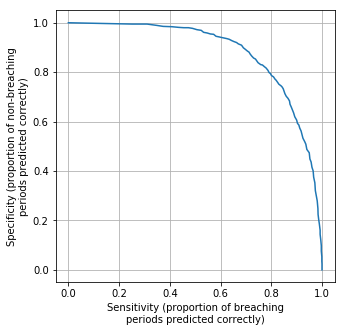

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

x = sensitivity_results
y = specificity_results

ax1.grid(True, which='both')
ax1.set_xlabel('Sensitivity (proportion of breaching\nperiods predicted correctly)')
ax1.set_ylabel('Specificity (proportion of non-breaching\nperiods predicted correctly)')


plt.plot(x,y)
plt.show()

Plotting specificity against sensitivity shows we can adjust our machine learning cut-off to simultaneously achieve 80% accuracy in predicting likelihood of breaches in the next 2 hours.